<a href="https://colab.research.google.com/github/224312031k/YAPAYS-N-R-A-LARI/blob/main/Face_Mask_Detection_224312031.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Gerekli kütüphanelerin yüklenmesi
!pip install numpy pandas matplotlib seaborn tensorflow keras scikit-learn


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
import zipfile

# Zip dosyasının yolu
zip_path = "/content/drive/My Drive/yapaysinir/archive (1).zip"
# Çıkarılacak klasörün yolu
extract_path = "/content/veri_seti"

# Zip dosyasını çıkar
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dosya başarıyla çıkarıldı ve içerikler şu klasöre taşındı:", extract_path)


Dosya başarıyla çıkarıldı ve içerikler şu klasöre taşındı: /content/veri_seti


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Eğitim ve doğrulama veri seti için ayırma oranları
train_dir = '/content/veri_seti/data'

# Eğitim için veri artırma (Data Augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # %20 validation set
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Eğitim seti
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resim boyutu
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Doğrulama seti
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 6043 images belonging to 2 classes.
Found 1510 images belonging to 2 classes.


In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Önceden eğitilmiş MobileNetV2 modeli
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Modelin önceden eğitilmiş katmanlarını donduruyoruz
base_model.trainable = False

# Yeni sınıflandırma katmanları ekleme
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)  # 2 sınıf olduğu için çıkış katmanı

# Modeli tanımlama
model = Model(inputs=base_model.input, outputs=predictions)

from tensorflow.keras.optimizers import Adam

# Modelin derlenmesi
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Öğrenme oranını 0.001 olarak ayarlıyoruz
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# Modelin özetini yazdırma
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
# Eğitim parametreleri
epochs = 100  # Eğitim döngü sayısı
batch_size = 32  # Her adımda işlenecek örnek sayısı

# Sınıf ağırlıklarının hesaplanması
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Sınıflar ve etiketler
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Sınıf ağırlıklarını bir sözlük olarak tanımla
class_weights_dict = dict(enumerate(class_weights))

# Modelin eğitilmesi
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=epochs,  # Burada tanımladığın epochs kullanılıyor
    class_weight=class_weights_dict  # Sınıf ağırlıkları burada eklendi
)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 45/188 ━━━━━━━━━━━━━━━━━━━━ 5:20 2s/step - accuracy: 0.7819 - loss: 0.5373

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 477s 2s/step - accuracy: 0.8966 - loss: 0.2645 - val_accuracy: 0.9701 - val_loss: 0.0878
Epoch 2/5
  1/188 ━━━━━━━━━━━━━━━━━━━━ 3:46 1s/step - accuracy: 1.0000 - loss: 0.0456

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 0.0456 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 444s 2s/step - accuracy: 0.9778 - loss: 0.0674 - val_accuracy: 0.9741 - val_loss: 0.0774
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 1.0000 - loss: 0.0371 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 454s 2s/step - accuracy: 0.9780 - loss: 0.0697 - val_accuracy: 0.9814 - val_loss: 0.0680


In [9]:
steps_per_epoch = len(train_generator)  # Eğitim setindeki toplam batch sayısını hesaplar
validation_steps = len(validation_generator)  # Doğrulama setindeki toplam batch sayısını hesaplar


In [10]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size


In [11]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=100
)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 469s 2s/step - accuracy: 0.9799 - loss: 0.0544 - val_accuracy: 0.9801 - val_loss: 0.0715
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 1.0000 - loss: 0.0061 - val_accuracy: 1.0000 - val_loss: 0.0156
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 464s 2s/step - accuracy: 0.9821 - loss: 0.0503 - val_accuracy: 0.9834 - val_loss: 0.0529
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - loss: 0.0051 - val_accuracy: 1.0000 - val_loss: 6.8948e-04
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 496s 2s/step - accuracy: 0.9820 - loss: 0.0532 - val_accuracy: 0.9688 - val_loss: 0.0804
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9375 - loss: 0.0966 - val_accuracy: 1.0000 - val_loss: 0.0066
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 497s 2s/step - accuracy: 0.9831 - loss: 0.0534 - val_accuracy: 0.9801 - val_loss: 0.0694
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - loss: 0.0153 - val_accu

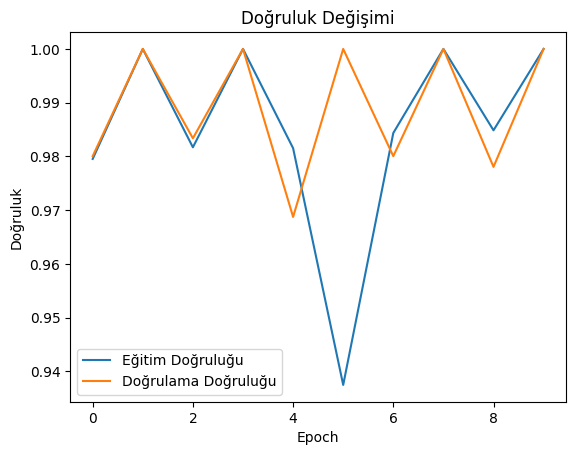

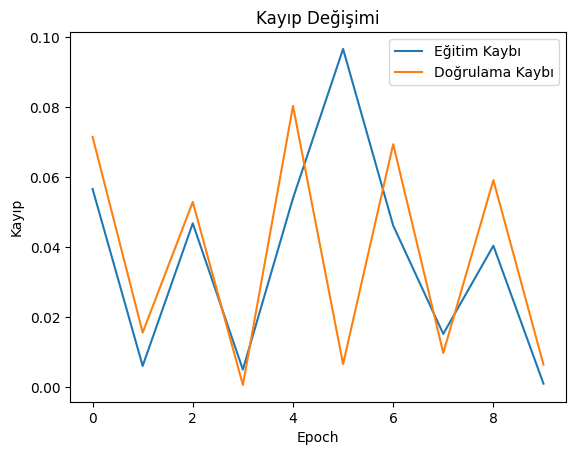

In [12]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama doğruluğu
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.title('Doğruluk Değişimi')
plt.show()

# Eğitim ve doğrulama kaybı
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.title('Kayıp Değişimi')
plt.show()


In [13]:
model.save('/content/drive/My Drive/yapaysinir/mask_detection_model.h5')
print("Model başarıyla kaydedildi!")


Model başarıyla kaydedildi!


In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callback'leri tanımlama
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=25,  # 25 epok boyunca iyileşme olmazsa eğitim duracak
    restore_best_weights=True  # En iyi ağırlıklar geri yüklenecek
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Öğrenme oranı 0.2 ile çarpılacak
    patience=25,  # 2 epok boyunca iyileşme olmazsa uygulanacak
    min_lr=1e-6  # Minimum öğrenme oranı
)

# Modeli tekrar eğitme
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,  # Eğitilecek epok sayısı
    callbacks=[early_stopping, reduce_lr]  # Callback'leri dahil et
)


Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 510s 3s/step - accuracy: 0.9839 - loss: 0.0441 - val_accuracy: 0.9755 - val_loss: 0.0737 - learning_rate: 0.0010
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 512s 3s/step - accuracy: 0.9882 - loss: 0.0380 - val_accuracy: 0.9808 - val_loss: 0.0802 - learning_rate: 0.0010
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 510s 3s/step - accuracy: 0.9857 - loss: 0.0361 - val_accuracy: 0.9828 - val_loss: 0.0556 - learning_rate: 0.0010
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 515s 2s/step - accuracy: 0.9862 - loss: 0.0419 - val_accuracy: 0.9821 - val_loss: 0.0673 - learning_rate: 0.0010
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 501s 2s/step - accuracy: 0.9864 - loss: 0.0361 - val_accuracy: 0.9821 - val_loss: 0.0657 - learning_rate: 0.0010
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 464s 2s/step - accuracy: 0.9892 - loss: 0.0258 - val_accuracy: 0.9834 - val_loss: 0.0523 - learning_rate: 2.0000e-04
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 456s 2s/step - accuracy: 0.9904 - loss

In [15]:
from tensorflow.keras.callbacks import Callback

# Öğrenme oranını her epoch sonunda yazdıran özel bir callback
class LearningRateLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = float(self.model.optimizer.learning_rate.numpy())
        print(f"Epoch {epoch + 1}: Current Learning Rate: {lr}")


In [16]:
model.save('/content/drive/My Drive/yapaysinir/mask_detection_model.keras')
print("En iyi model Keras formatında başarıyla kaydedildi!")


En iyi model Keras formatında başarıyla kaydedildi!


In [17]:
import os
from PIL import Image

# Veri setindeki tüm resimleri RGB'ye dönüştür
image_dir = "/content/veri_seti/data"  # Resimlerin olduğu klasör
for folder in os.listdir(image_dir):
    folder_path = os.path.join(image_dir, folder)
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        with Image.open(image_path) as img:
            img = img.convert("RGB")  # Görseli RGB formatına dönüştür
            img.save(image_path)  # Orijinal dosyayı yeniden kaydet


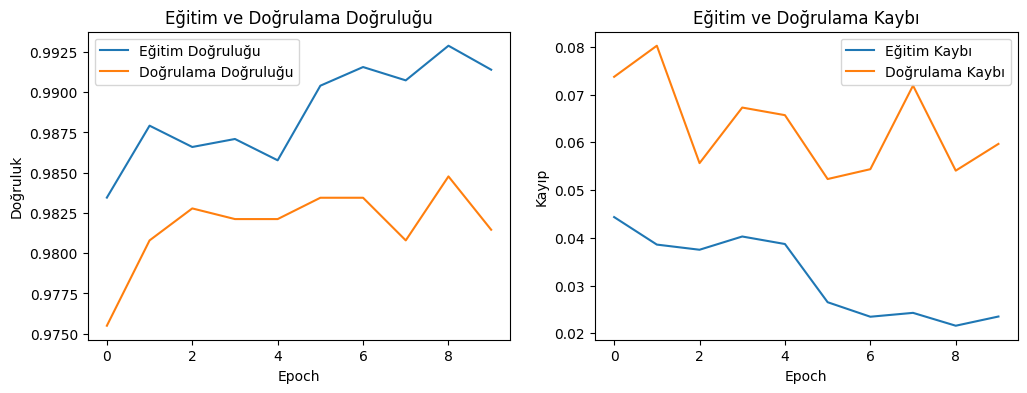

In [18]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama kayıplarını çizdirme
plt.figure(figsize=(12, 4))

# Eğitim ve doğrulama doğrulukları
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

# Eğitim ve doğrulama kayıpları
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.show()


In [19]:
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f"Test Doğruluğu: {test_accuracy * 100:.2f}%")
print(f"Test Kaybı: {test_loss:.4f}")


48/48 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9761 - loss: 0.0933
Test Doğruluğu: 98.48%
Test Kaybı: 0.0576


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


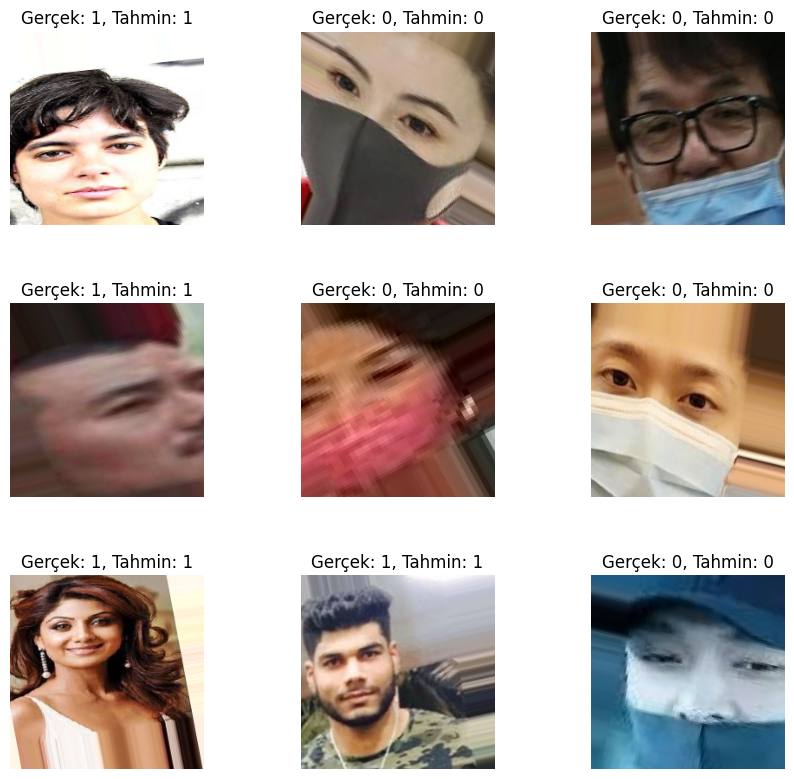

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Validation setten rastgele bir batch alın
images, labels = next(validation_generator)

# Model tahminleri
predictions = model.predict(images)

# Görüntüleri ve tahminleri görselleştirme
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.ravel()

for i in np.arange(0, 9):
    axes[i].imshow(images[i])
    axes[i].set_title(f"Gerçek: {np.argmax(labels[i])}, Tahmin: {np.argmax(predictions[i])}")
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)
plt.show()


In [21]:
# Doğrulama seti üzerindeki tahminler
validation_generator.reset()  # Veri sırasını sıfırlamak için
predictions = model.predict(validation_generator, verbose=1)

# Tahmin edilen sınıflar
predicted_classes = predictions.argmax(axis=-1)

# Gerçek sınıflar
true_classes = validation_generator.classes[:len(predicted_classes)]  # Uzunluk uyumsuzluğu için düzeltiyoruz

# Sınıf etiketleri
class_labels = list(validation_generator.class_indices.keys())


48/48 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step


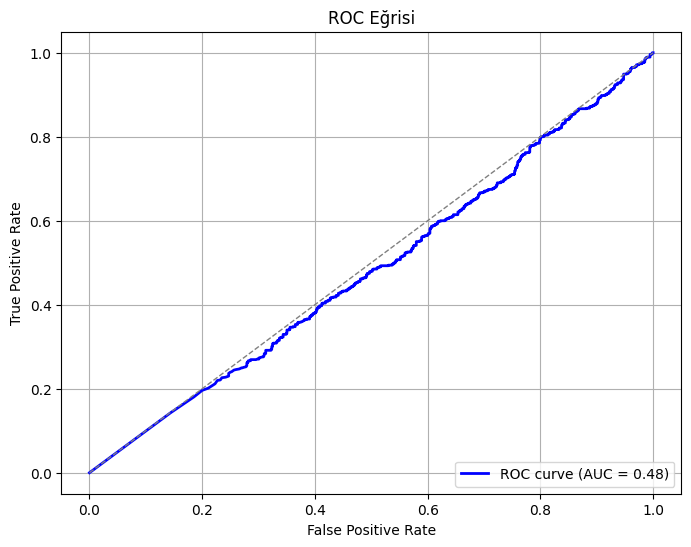

In [26]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Gerçek ve tahmin edilen sınıflar
true_classes_binarized = label_binarize(true_classes, classes=[0, 1])  # Sınıflar 0 ve 1 için
predicted_probabilities = predictions[:, 1]  # Pozitif sınıfın olasılıkları

# ROC eğrisi hesaplama
fpr, tpr, _ = roc_curve(true_classes_binarized, predicted_probabilities)
roc_auc = auc(fpr, tpr)

# ROC eğrisini çizdirme
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrisi')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Metriklerin hesaplanması
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

# Specificity (Özgüllük) hesaplama
cm = confusion_matrix(true_classes, predicted_classes)
tn, fp, fn, tp = cm.ravel()  # Pozitif/negatif değerleri ayırma
specificity = tn / (tn + fp)

# Sonuçları yazdırma
print(f"Accuracy (Doğruluk): {accuracy:.2f}")
print(f"Precision (Duyarlılık): {precision:.2f}")
print(f"Recall (Hassasiyet): {recall:.2f}")
print(f"Specificity (Özgüllük): {specificity:.2f}")
print(f"F1-Score: {f1:.2f}")


Accuracy (Doğruluk): 0.49
Precision (Duyarlılık): 0.49
Recall (Hassasiyet): 0.49
Specificity (Özgüllük): 0.48
F1-Score: 0.49


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

# MLP Modeli
mlp_model = Sequential([
    Flatten(input_shape=(224, 224, 3)),  # Resimleri düzleştir
    Dense(512, activation='relu'),  # İlk gizli katman
    Dropout(0.5),  # Dropout
    Dense(256, activation='relu'),  # İkinci gizli katman
    Dropout(0.5),
    Dense(2, activation='softmax')  # Çıkış katmanı
])

# Modelin derlenmesi
mlp_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Modelin özeti
mlp_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      77,070,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,202,690 (294.50 MB)

 Trainable params: 77,202,690 (294.50 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Modeli derleme
mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Eğitim parametreleri
epochs = 100
batch_size = 32

# Modeli eğitme
mlp_history = mlp_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 453s 2s/step - accuracy: 0.5279 - loss: 42.8279 - val_accuracy: 0.5133 - val_loss: 0.6891
Epoch 2/10
  1/188 ━━━━━━━━━━━━━━━━━━━━ 4:30 1s/step - accuracy: 0.5312 - loss: 0.6924

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.5312 - loss: 0.6924 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 432s 2s/step - accuracy: 0.4994 - loss: 0.7262 - val_accuracy: 0.4973 - val_loss: 0.6917
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.3438 - loss: 0.6944 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 421s 2s/step - accuracy: 0.5046 - loss: 0.7001 - val_accuracy: 0.5060 - val_loss: 0.6955
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 563us/step - accuracy: 0.6250 - loss: 0.6920 - val_accuracy: 0.6667 - val_loss: 0.6926
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 430s 2s/step - accuracy: 0.5072 - loss: 0.6936 - val_accuracy: 0.5060 - val_loss: 0.6918
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 404us/step - accuracy: 0.4688 - loss: 0.6928 - val_accuracy: 0.6667 - val_loss: 0.6903
Epoch 9/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 431s 2s/step - accuracy: 0.5206 - loss: 0.6937 - val_accuracy: 0

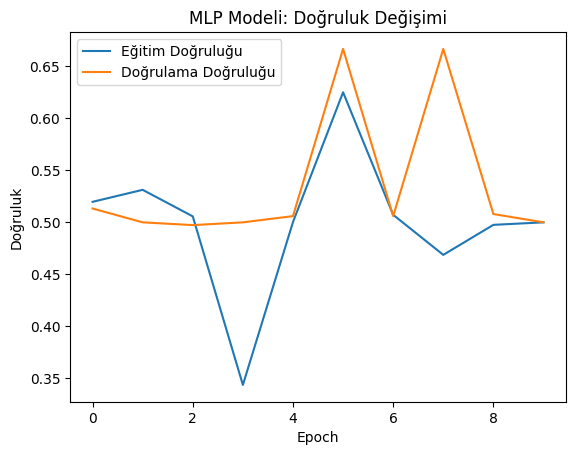

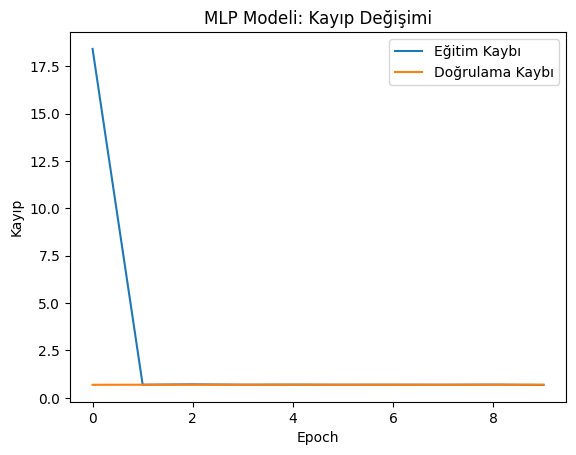

In [30]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama doğruluğu
plt.plot(mlp_history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(mlp_history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.title('MLP Modeli: Doğruluk Değişimi')
plt.show()

# Eğitim ve doğrulama kaybı
plt.plot(mlp_history.history['loss'], label='Eğitim Kaybı')
plt.plot(mlp_history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.title('MLP Modeli: Kayıp Değişimi')
plt.show()


In [31]:
# Test setinde modelin performansı
mlp_test_loss, mlp_test_accuracy = mlp_model.evaluate(validation_generator)
print(f"MLP Test Doğruluğu: {mlp_test_accuracy * 100:.2f}%")
print(f"MLP Test Kaybı: {mlp_test_loss:.4f}")


48/48 ━━━━━━━━━━━━━━━━━━━━ 30s 629ms/step - accuracy: 0.5184 - loss: 0.6926
MLP Test Doğruluğu: 50.66%
MLP Test Kaybı: 0.6922


48/48 ━━━━━━━━━━━━━━━━━━━━ 34s 713ms/step


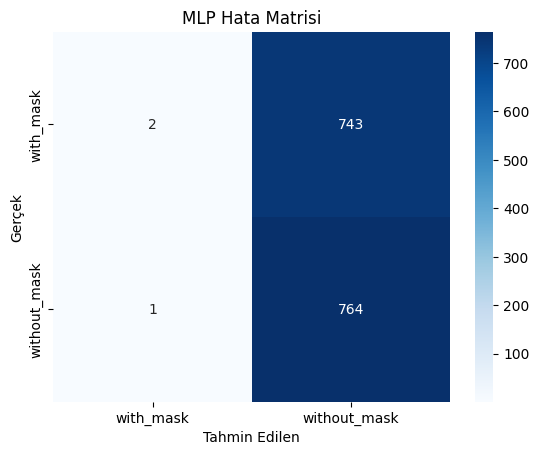

              precision    recall  f1-score   support

   with_mask       0.67      0.00      0.01       745
without_mask       0.51      1.00      0.67       765

    accuracy                           0.51      1510
   macro avg       0.59      0.50      0.34      1510
weighted avg       0.59      0.51      0.34      1510



In [32]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Tahminler
mlp_predictions = mlp_model.predict(validation_generator)
mlp_predicted_classes = mlp_predictions.argmax(axis=-1)
mlp_true_classes = validation_generator.classes[:len(mlp_predicted_classes)]
mlp_class_labels = list(validation_generator.class_indices.keys())

# Hata matrisi
mlp_cm = confusion_matrix(mlp_true_classes, mlp_predicted_classes)
sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Blues', xticklabels=mlp_class_labels, yticklabels=mlp_class_labels)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('MLP Hata Matrisi')
plt.show()

# Performans metrikleri
print(classification_report(mlp_true_classes, mlp_predicted_classes, target_names=mlp_class_labels))


48/48 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step


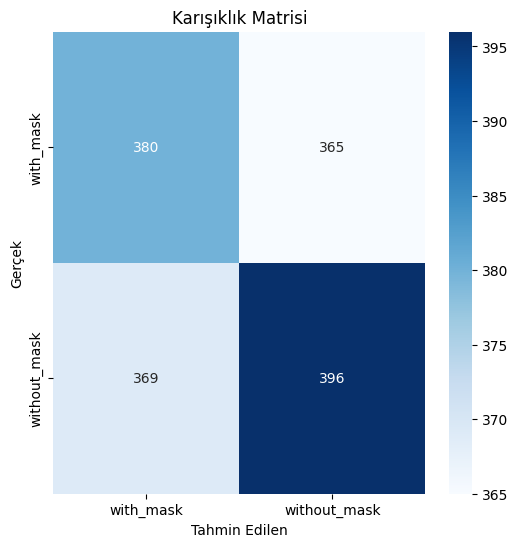

In [35]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Gerçek ve tahmin edilen sınıfları al
true_classes = validation_generator.classes  # Gerçek etiketler
predicted_classes = model.predict(validation_generator)
predicted_classes = np.argmax(predicted_classes, axis=1)  # En yüksek olasılığı alan sınıf

# Sınıf etiketlerini al
class_labels = list(validation_generator.class_indices.keys())

# Karışıklık Matrisini Hesapla
cm = confusion_matrix(true_classes, predicted_classes)

# Karışıklık Matrisini Görselleştir
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Karışıklık Matrisi')
plt.show()



48/48 ━━━━━━━━━━━━━━━━━━━━ 31s 634ms/step


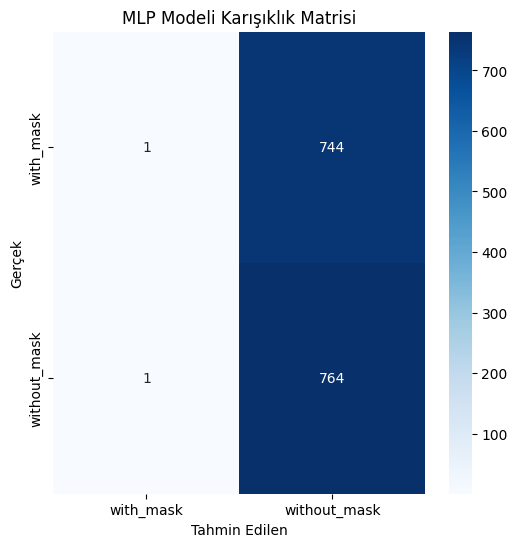

In [36]:
# Gerçek etiketler
true_classes_mlp = validation_generator.classes

# MLP modelinin tahminleri
predicted_classes_mlp = mlp_model.predict(validation_generator)
predicted_classes_mlp = np.argmax(predicted_classes_mlp, axis=1)

# Karışıklık Matrisini Hesapla
cm_mlp = confusion_matrix(true_classes_mlp, predicted_classes_mlp)

# Karışıklık Matrisini Görselleştir
plt.figure(figsize=(6,6))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('MLP Modeli Karışıklık Matrisi')
plt.show()
